## <div align='center'><font size="6" color="#1a0d0d">Актуальні вакансії на ринку праці</font></div>

## <div align='left'><font size="5" color="#1a0d0d">Про датасет</font></div>
<div align='left'><font size="3" color="#1a0d0d">Даний перелік містить інформацію про вакансії, подані роботодавцями до державної служби зайнятості за формою звітності № 3-ПН, що є актуальними на дату (час) формування переліку, і на які здійснюється набір претендентів.</font></div>

## <div align='left'><font size="5" color="#1a0d0d">Імпортування бібліотек та датасету</font></div>

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import numpy as np
from wordcloud import WordCloud
from collections import Counter

In [2]:
vacancies_df = pd.read_xml("vac20230427.xml")

## <div align='left'><font size="5" color="#1a0d0d">Огляд даних</font></div>

In [3]:
vacancies_df.head(3)

,id,link,name,region,description,pubdate,salary,company,expire,jobtype,phone,email
0,1088867541,![CDATA[https://www.dcz.gov.ua/userSearch/vaca...,![CDATA[Вчитель закладу загальної середньої ос...,"![CDATA[М.Київ, Голосіївський]]",![CDATA[<div>\n<p>Заробітна плата (усього): 80...,07.09.2022,![CDATA[8000₴ за місяць]],"![CDATA[279, ГОЛОСІЇВСЬКА РАЙОННА ФІЛІЯ КИЇВСЬ...",22.12.2022,![CDATA[вакансія]],![CDATA[0675207428]],None
1,1088867561,![CDATA[https://www.dcz.gov.ua/userSearch/vaca...,![CDATA[Практичний психолог]],"![CDATA[Хмельницька область, Шепетівський райо...",![CDATA[<div>\n<p>Заробітна плата (усього): 70...,15.09.2022,![CDATA[7000₴ за місяць]],"![CDATA[2219, Шепетівський МРЦЗ]]",22.12.2022,![CDATA[вакансія]],"![CDATA[0384040845, 80384040843]]",None
2,1088910601,![CDATA[https://www.dcz.gov.ua/userSearch/vaca...,![CDATA[робітник з благоустрою]],"![CDATA[Миколаївська область, Вознесенський ра...",![CDATA[<div>\n<p>Заробітна плата (усього): 67...,03.10.2022,![CDATA[6700₴ за місяць]],"![CDATA[1451, Вознесенська міськрайонна філія ...",22.12.2022,![CDATA[вакансія]],![CDATA[(05134)3-26-64]],None


In [4]:
vacancies_df.nunique()

id             17399
link           17399
name            1579
region          2495
description    16462
pubdate          387
salary          1535
company          922
expire            28
jobtype            1
phone            863
email             91
dtype: int64

<div align='left'><font size="3" color="#1a0d0d">Дані включають айді вакансії, посилання на неї, повну назву, регіон, опис, дату публікації, оголошену заробітню плату, компанію, дату сроку закінчення вакансії, тип вакансії, вказаний телефон та електронну пошту. </font></div>

## <div align='left'><font size="5" color="#1a0d0d">Очищення даних</font></div>

In [5]:
oblast_dict = {" Кіровоградська область": 'Kirovohradska oblast',
               " Дніпропетровська область": 'Dnipropetrovska oblast',
               " Миколаївська область": 'Mykolaivska oblast',
               " Сумська область": 'Sumska oblast',
               " Львівська область": 'Lvivska oblast',
               " Полтавська область": 'Poltavska oblast',
               " Одеська область": 'Odeska oblast',
               " Рівненська область": 'Rivnenska oblast',
               " Черкаська область": 'Cherkaska oblast',
               " Харківська область": 'Kharkivska oblast',
               " Херсонська область": 'Khersonska oblast',
               " Запорізька область": 'Zaporizka oblast',
               " Чернівецька область": 'Chernivetska oblast',
               " Хмельницька область": 'Khmelnytska oblast',
               " Волинська область": 'Volynska oblast',
               " Житомирська область": 'Zhytomyrska oblast',
               " Івано-Франківська область": 'Ivano-frankivska oblast',
               " Тернопільська область": 'Ternopilska oblast',
               " Чернігівська область": 'Chernihivska oblast',
               " Київська область": 'Kyivska oblast',
               " Вінницька область": 'Vinnytska oblast',
               " Закарпатська область": 'Zakarpatska oblast',
               " Донецька область": 'Donetska oblast',
               " Луганська область": 'Luhanska oblast'
              }

In [6]:
def clean_dataset(data):
    # Видаляємо лишній текст у рядках
    data = data.replace({'!\[CDATA\[': ' ', "\]\]": " "}, regex=True)
    # Прибираємо стовпці, які не знадобляться у подальшому аналізі
    data.drop(['jobtype', 'phone', 'email', 'link', 'description'], axis=1, inplace=True)
    # Розбиваємо колонку із заробітньої платою на дві: зп у цифрах та за який період
    data[['amount', 'cpm']] = data['salary'].str.extract(r'(\d*)(₴.*)')
    # Звужуємо регіон до рівня областей
    data['region'] = data['region'].str.extract(r'(.*область)')
    # Перетворюємо колонку із зп у числову
    data['amount'] = pd.to_numeric(data['amount'])
    # Перетворюємо колонку із датами публікації та сроку до типу данних дати
    data[['pubdate', 'expire']] = data[['pubdate', 'expire']].apply(pd.to_datetime, dayfirst=True)
    # Створюємо стовпчик із назвами областей транслітом для подальшого аналізу
    data['region_eng'] = data['region'].map(oblast_dict)
    # Видаємо рядки із пустими значеннями
    data = data.dropna()
    # Видаляємо дані за минулі роки
    data = data[~(data['pubdate'] < '2022-01-01')]
    return data

In [7]:
vacancies_df = clean_dataset(vacancies_df)
vacancies_df.head(3)

,id,name,region,pubdate,salary,company,expire,amount,cpm,region_eng
1,1088867561,Практичний психолог,Хмельницька область,2022-09-15,7000₴ за місяць,"2219, Шепетівський МРЦЗ",2022-12-22,7000,₴ за місяць,Khmelnytska oblast
2,1088910601,робітник з благоустрою,Миколаївська область,2022-10-03,6700₴ за місяць,"1451, Вознесенська міськрайонна філія Миколаї...",2022-12-22,6700,₴ за місяць,Mykolaivska oblast
4,1088868446,кухар,Івано-Франківська область,2022-09-28,9000₴ за місяць,"905, ІФМЦЗ",2022-12-22,9000,₴ за місяць,Ivano-frankivska oblast


In [8]:
date_range = str(vacancies_df['pubdate'].dt.date.min()) + ' to ' +str(vacancies_df['pubdate'].dt.date.max())
print(date_range)
date_range2 = str(vacancies_df['expire'].dt.date.min()) + ' to ' +str(vacancies_df['expire'].dt.date.max())
print(date_range2)

2022-01-04 to 2023-04-26
2022-12-22 to 2023-04-26


In [9]:
# mask = (vacancies_df['pubdate'] > '2020-01-01') & (vacancies_df['pubdate'] <= '2020-12-31')
# vacancies_df.loc[mask]

In [10]:
# mask = (vacancies_df['pubdate'] > '2021-01-01') & (vacancies_df['pubdate'] <= '2021-12-31')
# vacancies_df.loc[mask].head()

## <div align='left'><font size="5" color="#1a0d0d">Перевірка</font></div>

In [11]:
vacancies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14766 entries, 1 to 17397
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          14766 non-null  int64         
 1   name        14766 non-null  object        
 2   region      14766 non-null  object        
 3   pubdate     14766 non-null  datetime64[ns]
 4   salary      14766 non-null  object        
 5   company     14766 non-null  object        
 6   expire      14766 non-null  datetime64[ns]
 7   amount      14766 non-null  int64         
 8   cpm         14766 non-null  object        
 9   region_eng  14766 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 1.2+ MB


In [12]:
vacancies_df.nunique()

id            14766
name           1464
region           23
pubdate         216
salary         1343
company         770
expire           27
amount         1280
cpm               1
region_eng       23
dtype: int64

In [13]:
vacancies_df.shape

(14766, 10)

## <div align='left'><font size="5" color="#1a0d0d">Запис датасету до файлу Excel</font></div>

In [14]:
vacancies_df.to_excel('vacancies.xlsx')

## <div align='left'><font size="5" color="#1a0d0d">Аналіз</font></div>

In [15]:
# Створення кольорових мап
# Перша кольорова мапа
N = 256
pastel = np.ones((N, 4))
pastel[:, 0] = np.linspace(216/256, 1, N) # R = 255
pastel[:, 1] = np.linspace(169/256, 1, N) # G = 232
pastel[:, 2] = np.linspace(144/256, 1, N)  # B = 11
pastel_cmp = ListedColormap(pastel)

blue = np.ones((N, 4))
blue[:, 0] = np.linspace(34/256, 1, N)
blue[:, 1] = np.linspace(120/256, 1, N)
blue[:, 2] = np.linspace(176/256, 1, N)
blue_cmp = ListedColormap(blue)

newcolors1 = np.vstack((pastel_cmp(np.linspace(0, 1, 128)),
                       blue_cmp(np.linspace(1, 0, 128))))
cmap_1 = ListedColormap(newcolors1)
back_1 = '#191F2C'

# Друга кольорова мапа
red = np.ones((N, 4))
red[:, 0] = np.linspace(245/256, 1, N) # R = 255
red[:, 1] = np.linspace(66/256, 1, N) # G = 232
red[:, 2] = np.linspace(66/256, 1, N)  # B = 11
red_cmp = ListedColormap(red)

grey = np.ones((N, 4))
grey[:, 0] = np.linspace(184/256, 1, N)
grey[:, 1] = np.linspace(178/256, 1, N)
grey[:, 2] = np.linspace(173/256, 1, N)
grey_cmp = ListedColormap(grey)

newcolors2 = np.vstack((red_cmp(np.linspace(0, 1, 128)),
                       grey_cmp(np.linspace(1, 0, 128))))
cmap_2 = ListedColormap(newcolors2)
back_2 = '#1c1717'
back = '#17171c'

# Третя кольорова мапа
red2 = np.ones((N, 4))
red2[:, 0] = np.linspace(201/256, 1, N) # R = 255
red2[:, 1] = np.linspace(21/256, 1, N) # G = 232
red2[:, 2] = np.linspace(19/256, 1, N)  # B = 11
red2_cmp = ListedColormap(red2)

grey2 = np.ones((N, 4))
grey2[:, 0] = np.linspace(179/256, 1, N)
grey2[:, 1] = np.linspace(154/256, 1, N)
grey2[:, 2] = np.linspace(154/256, 1, N)
grey2_cmp = ListedColormap(grey2)

newcolors3 = np.vstack((red2_cmp(np.linspace(0, 1, 128)),
                       grey2_cmp(np.linspace(1, 0, 128))))
cmap_3 = ListedColormap(newcolors3)
back_3 = '#F5E4E4'

(-0.5, 2999.5, 2499.5, -0.5)

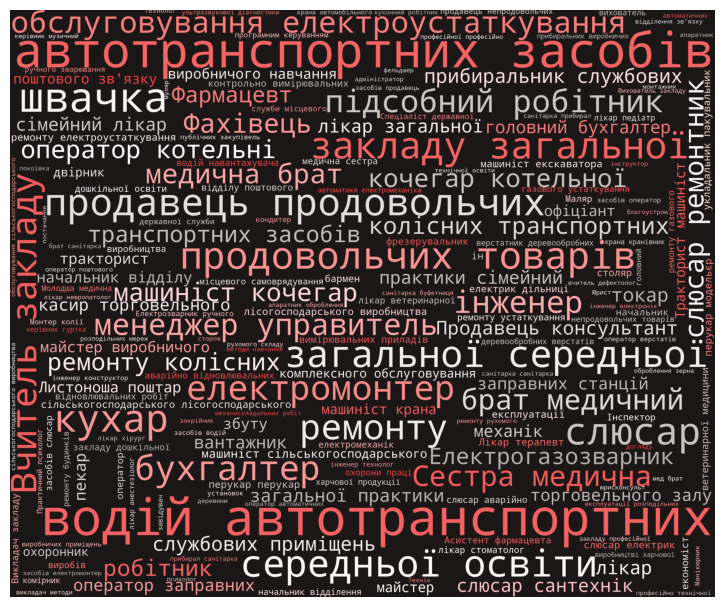

In [16]:
# Отримаємо текстову строку зі списку
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
        
#Українські стоп слова
def stop_words():
    stopwords = []
    with open('ukrwords_new.txt', encoding='utf-8') as r:
        for line in r:
            line = line.strip()
            stopwords.append(line)
    return stopwords
ukr_stopwords = stop_words()

#Створення списку усіх слів
all_words = []
for i in range(vacancies_df.shape[0]):
    text = vacancies_df.iloc[i]['name']
    for word in text.split(" "):
        if word:
            all_words.append(word)

# Створення хмарки слів
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color=back_2,
                              colormap=cmap_2,
                              stopwords=ukr_stopwords,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

procWordCloud = get_wordCloud(all_words)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

C:\Users\alexa\AppData\Local\Temp\ipykernel_14592\3204289346.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


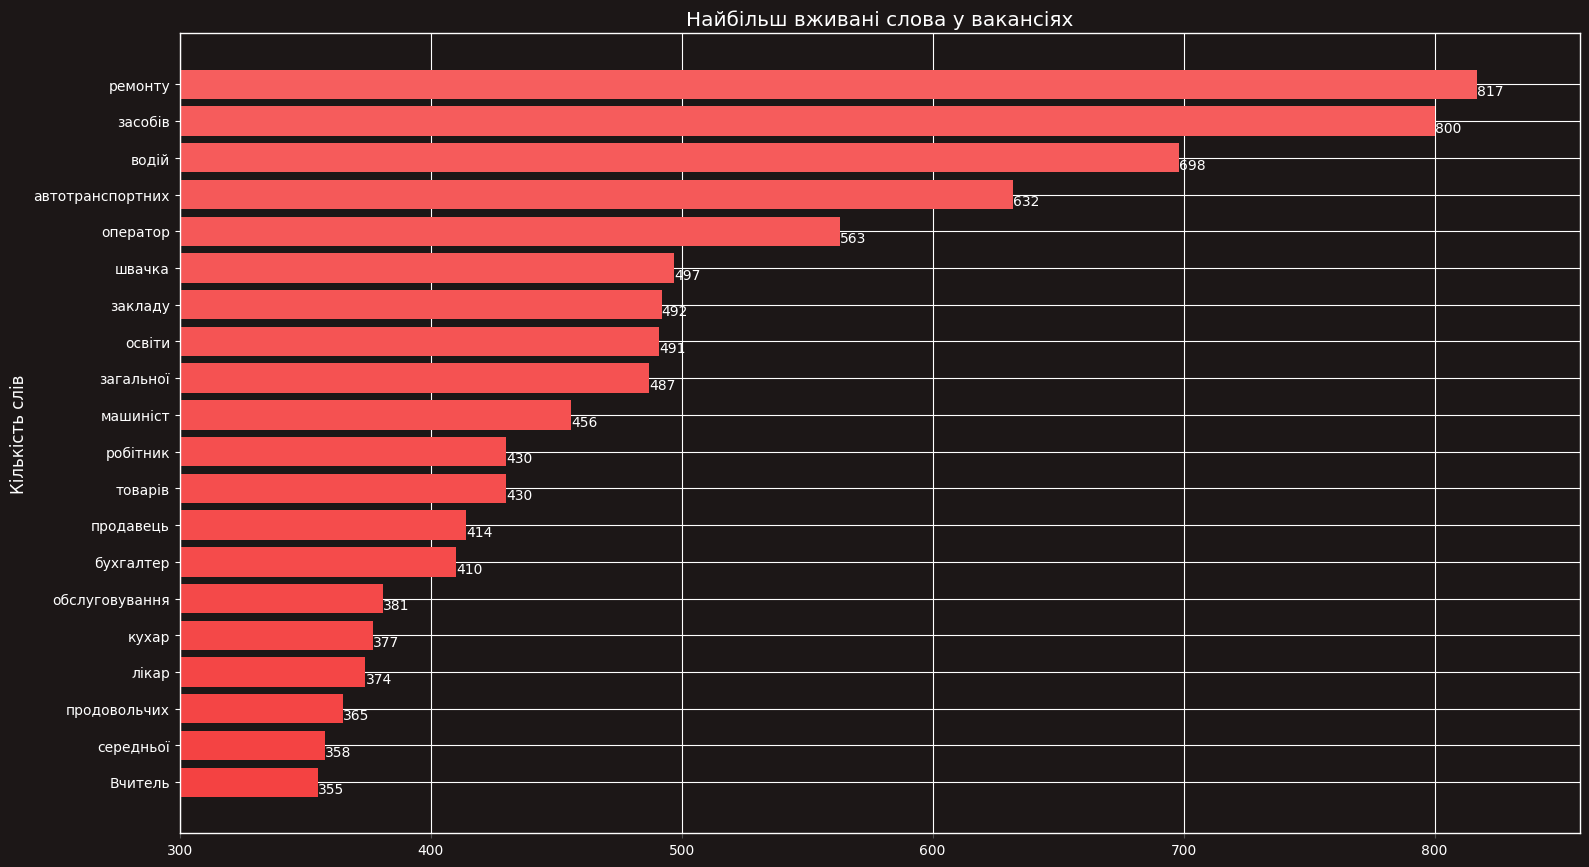

In [18]:
# Прибираємо стоп-слова
clean_words = []
for word in all_words:
    if word:
        if word not in ukr_stopwords:
            clean_words.append(word)

# top = Counter(" ".join(clean_words).split()).most_common(100)
top = Counter(clean_words)
y = [count for tag, count in top.most_common(20)[::-1]]
x = [tag for tag, count in top.most_common(20)[::-1]]

# Будуємо діаграму
fig = plt.figure(figsize=(14, 8))
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = back_2
ax = fig.add_axes([0,0,1,1])
ax.set_facecolor(back_2)
plt.barh(x, y, color=cmap_2.colors)
plt.title("Найбільш вживані слова у вакансіях", color='white')
plt.ylabel("Кількість слів", color='white')
plt.xticks(color='white')
plt.tick_params(axis='y', colors='white')
for i, (tag, count) in enumerate(top.most_common(20)[::-1]):
    plt.text(count, i, f'{count}',
            ha='left', va='top', color='white')
plt.xlim(300)
plt.tight_layout()
plt.show()